In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 2.1

In [2]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

#### Code 2.2

$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$


The probability of observing six W’s in nine tosses—under a value of p=0.5

In [3]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

#### Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book the following code is not inside a function, but this way is easier to play with different parameters

In [53]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9, prior=None):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    if prior is None:
        prior = np.repeat(5, grid_points)  # uniform
    #prior = (p_grid >= 0.5).astype(int)  # truncated
    #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

#### Code 2.3

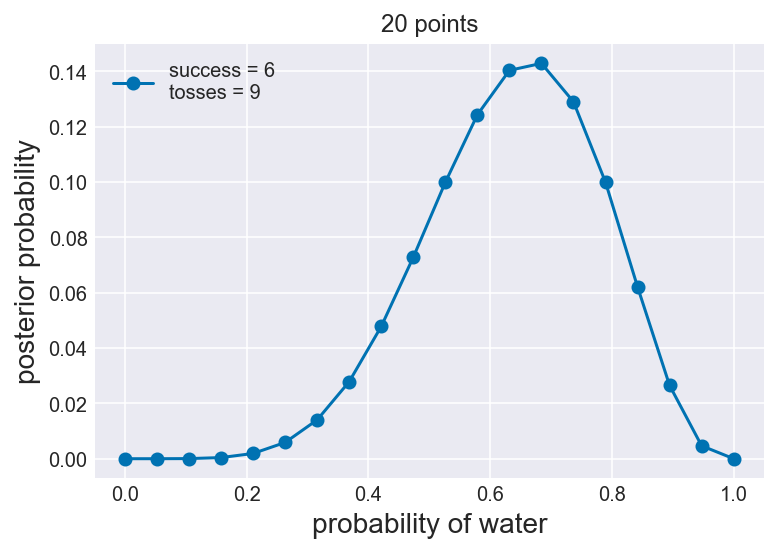

In [5]:
points = 20
w, n = 6, 9
p_grid, posterior = posterior_grid_approx(points, w, n)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

#### Code 2.6

Computing the posterior using the quadratic aproximation

In [6]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
print('Mean: ' + str(mean_q['p']))
print('StdDev: ' + str(std_q))
# mean_q['p'], std_q

/Users/joshuashapiro/.pyenv/versions/3.6.5/envs/rethinking/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 2232.88it/s]


Mean: 0.6666666671652423
StdDev: [0.15713484]


In [7]:
norm = stats.norm(mean_q, std_q)
prob = .89
z = stats.norm.ppf([(1-prob)/2, (1+prob)/2])
pi = mean_q['p'] + std_q * z 
print('5.5%: ' + str(pi[0]))
print('94.5%: ' + str(pi[1]))

5.5%: 0.41553484360077786
94.5%: 0.9177984907297068


#### Code 2.7

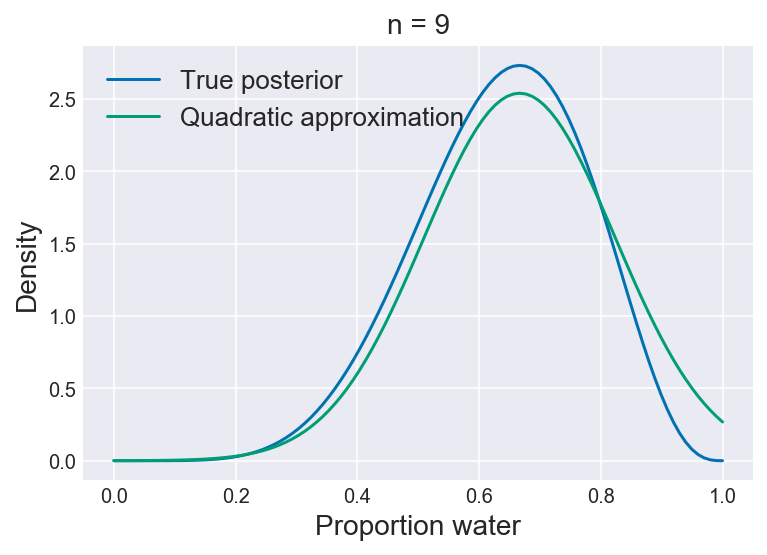

In [8]:
# analytical calculation
w, l = 6, 3
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, l+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title('n = {}'.format(w+l), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 2.8

In [43]:
n_samples = 1000
p = np.repeat(None, n_samples)
p[0] = 0.5
w = 6
l = 3
for i in range(1,n_samples):
    p_new = stats.norm(p[i-1], 0.1).rvs(size=1)[0]
    if p_new < 0:
        p_new = math.abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(w, w+l, p[i-1])
    q1 = stats.binom.pmf(w, w+l, p_new)
    if stats.uniform().rvs(size=1)[0] < q1/q0:
        p[i] = p_new
    else:
        p[i] = p[i-1]

#### Code 2.9

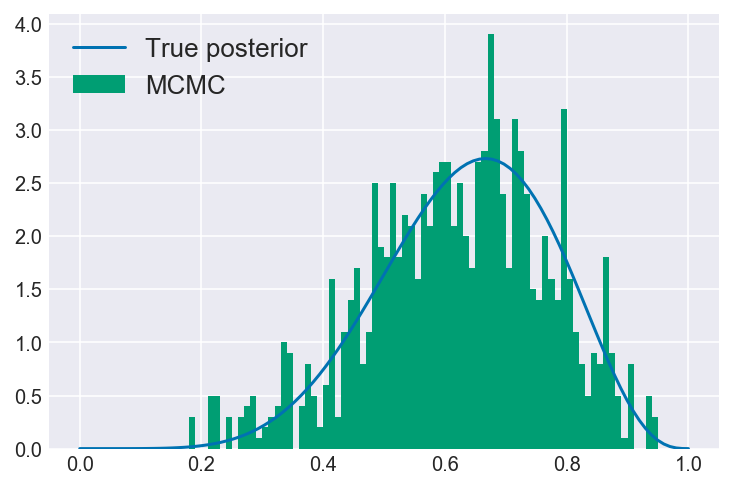

In [44]:
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, l+1),
          label='True posterior')

plt.hist(list(p), range=(0,1), density=True, bins=100, label="MCMC")
plt.legend(loc=0, fontsize=13)

### Book Problems

#### 2M1

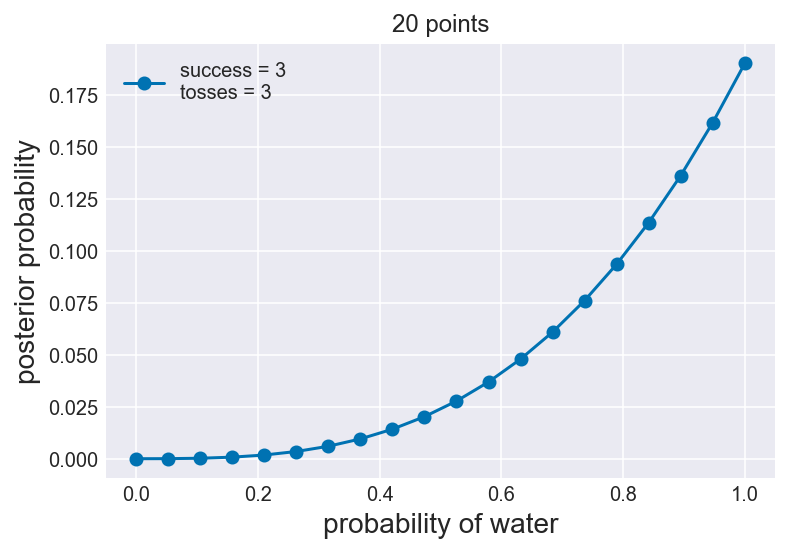

In [54]:
# 1
points = 20
w, n = 3, 3
prior = np.repeat(5, points)
p_grid, posterior = posterior_grid_approx(points, w, n, prior)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

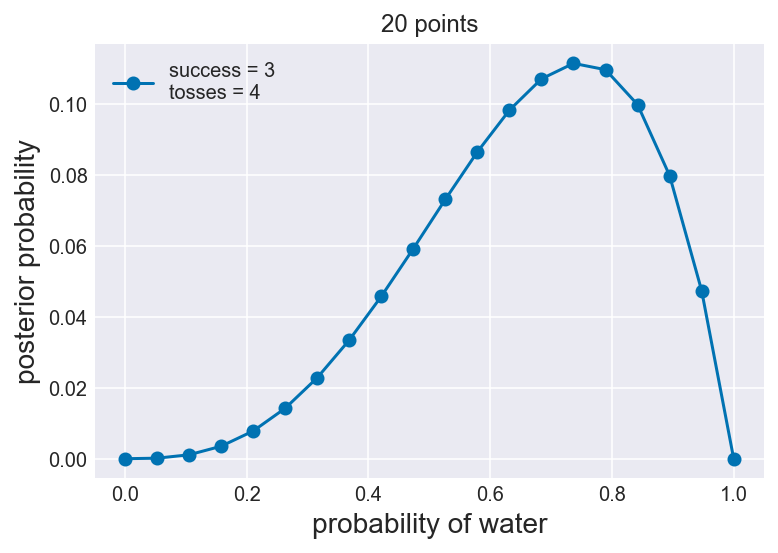

In [55]:
# 2
points = 20
w, n = 3, 4
prior = np.repeat(5, points)
p_grid, posterior = posterior_grid_approx(points, w, n, prior)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

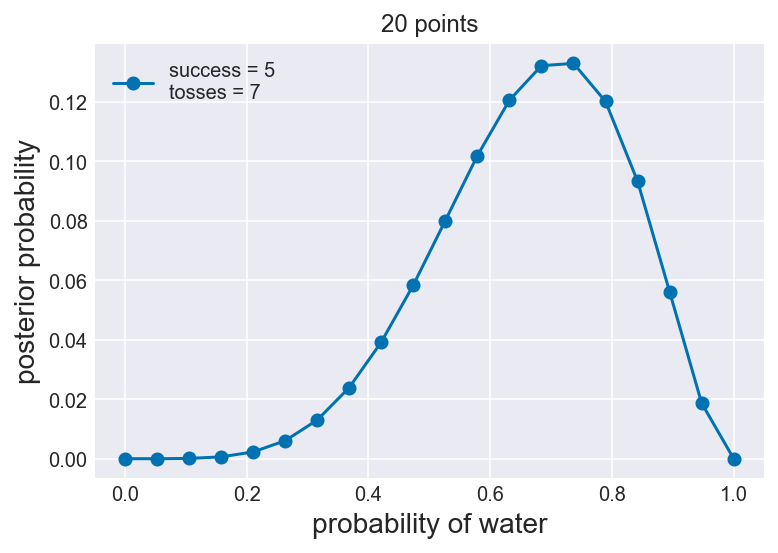

In [58]:
# 3
points = 20
w, n = 5, 7
prior = np.repeat(5, points)
p_grid, posterior = posterior_grid_approx(points, w, n, prior)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

#### 2M2

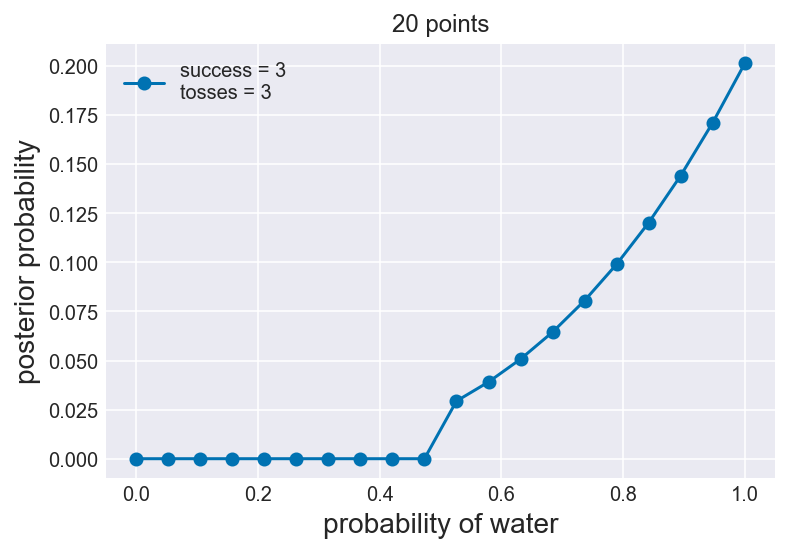

In [60]:
# 1
points = 20
w, n = 3, 3
prior = (np.linspace(0,1,points) >= 0.5).astype(int)
p_grid, posterior = posterior_grid_approx(points, w, n, prior)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

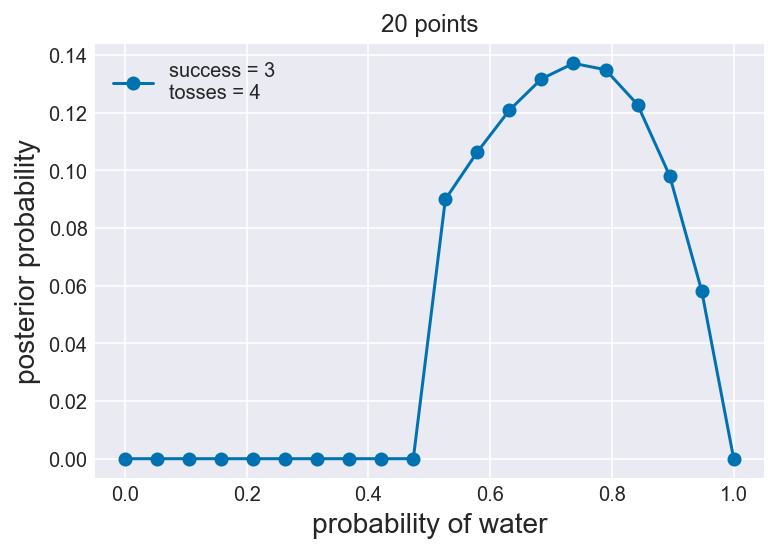

In [61]:
# 2
points = 20
w, n = 3, 4
prior = (np.linspace(0,1,points) >= 0.5).astype(int)
p_grid, posterior = posterior_grid_approx(points, w, n, prior)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

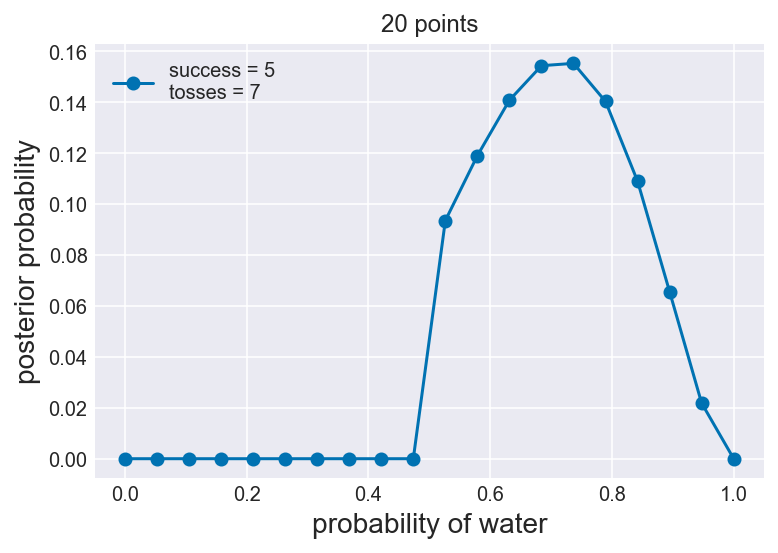

In [64]:
# 3
points = 20
w, n = 5, 7
prior = (np.linspace(0,1,points) >= 0.5).astype(int)
p_grid, posterior = posterior_grid_approx(points, w, n, prior)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

#### 2M3
Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know which—was tossed in the air and produced a “land” observation. Assume that each globe was equally likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on seeing “land” (Pr(Earth|land)), is 0.23.

In [3]:
# Posterior = prob of data * prior / avg. prob of data
# Pr(Earth|land) = Pr(land|Earth) * Pr(Earth) / Pr(Land)
p_land_given_earth = 0.3
p_earth = 0.5
p_land = (0.3 + 1) / 2

posterior = p_land_given_earth * p_earth / p_land
print(posterior)

0.23076923076923075


#### 2M4

Suppose you have a deck with only three cards. Each card has two sides, and each side is either black or white. One card has two black sides. The second card has one black and one white side. The third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up, but you don’t know the color of the side facing down. Show that the probability that the other side is also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This means counting up the ways that each card could produce the observed data (a black side facing up on the table).

- Card B/B: 2 ways
- Card W/B: 1 way
- Card W/W: 0 ways


- Total ways to see B: 3
- Possible ways for B/B: 2

2 / 3 = 2/3

#### 2M5

Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is drawn from the bag and a black side appears face up. Again calculate the probability that the other side is black.

- Card B/B: 2 ways
- Card B/B: 2 ways
- Card W/B: 1 way
- Card W/W: 0 ways


- Total ways to see B: 5
- Possible ways for B/B: 4

4 / 5 = 4/5

#### 2M6

Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that the probability the other side is black is now 0.5. Use the counting method, as before.

- Card B/B (1): 2 ways
- Card W/B (2): 1 ways
- Card W/W (3): 0 ways


- Total ways to see B: (2 * 1) + (1 * 2) + (0 * 3) = 4
- Possible ways for B/B: (2 * 1) = 2

2 / 4 = 0.5

#### 2M7

Assume again the original card problem, with a single card showing a black side face up.Before looking at the other side, we draw another card from the bag and lay it face up on the table. The face that is shown on the new card is white. Show that the probability that the first card, the one showing a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat this like the sequence of globe tosses, counting all the ways to see each observation, for each possible first card.

- B/B, W/B: 2 ways
- B/B, W/W: 4 ways
- W/B, B/B: 0 ways
- W/B, W/W: 2 ways
- W/W, B/B: 0 ways
- W/W, W/B: 0 ways


- Total possible ways to see B, W: 8
- Possible ways for B/B, W: 6
    

6/8 = 0.75

#### 2H1

Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research.

Now suppose you are managing a captive panda breeding program. You have a new female panda of unknown species, and she has just given birth to twins. What is the probability that her next birth will also be twins?

In [8]:
"""
posterior = likelihood * prior
Pr(twins_1) = Pr(twins|A) * Pr(species=A) + Pr(twins|B) * Pr(species=B)
Pr(twins_1) = 0.1 * 0.5 + 0.2 * 0.5 = 0.15
Pr(twins_2) = Pr(twins|A) * Pr(species=A|twins_1) + Pr(twins|B) * Pr(species=B|twins_1)

Pr(species=A|twins_1) = Pr(twins_1|A) * P(A) / Pr(twins_1)
Pr(species=B|twins_1) = Pr(twins_1|B) * P(B) / Pr(twins_1)

Pr(A|twins_1) = 0.1 * 0.5 / 0.15 = 0.333
Pr(B|twins_1) = 0.2 * 0.5 / 0.15 = 0.667
Pr(twins_2) = 0.1 * 0.33 + 0.2 * 0.67 = 0.167
"""
None

#### 2H2

Recall all the facts from the problem above. Now compute the probability that the panda we have is from species A, assuming we have observed only the first birth and that it was twins.

Pr(A|twins_1) = 0.1 * 0.5 / 0.15 = 0.333

#### 2H3

Continuing on from the previous problem, suppose the same panda mother has a second birth and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is species A.

Pr(A|twins, single) = Pr(twins, single|A) * Pr(A) / Pr(twins, single)

Pr(twins, single|A) = Pr(twins|A) * Pr(single|A)

Pr(twins, single) = Pr(twins, single|A) * Pr(A) + Pr(twins,single|B) * Pr(B)

Pr(A|twins, single) = (0.1 * 0.9 * 0.5) / (0.1 * 0.9 * 0.5 + 0.2 * 0.8 * 0.5) = 0.36

#### 2H4

A common boast of Bayesian statisticians is that Bayesian inference makes it easy to use all of the data, even if the data are of different types.
So suppose now that a veterinarian comes along who has a new genetic test that she claims can identify the species of our mother panda. But the test, like all tests, is imperfect. This is the information you have about the test:


- The probability it correctly identifies a species A panda is 0.8.
- The probability it correctly identifies a species B panda is 0.65.


The vet administers the test to your panda and tells you that the test is positive for species A. First ignore your previous information from the births and compute the posterior probability that your panda is species A. Then redo your calculation, now using the birth data as well.

Pr(species_A|test) = likelihood_A * prior / test=A

likelihood_A (test|A) = {A=0.8, B=0.35}

prior = {A=0.5, B=0.5}

test_A = 0.8*0.5 + 0.35*0.5

Pr(species_A|test) = (0.8 * 0.5) / 0.8*0.5 + 0.35*0.5 = 0.69

In [ ]:
Pr(species = A | test = A, twins, single) = ?

### Homework

#### 1)
Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. use the same flat prior as before.

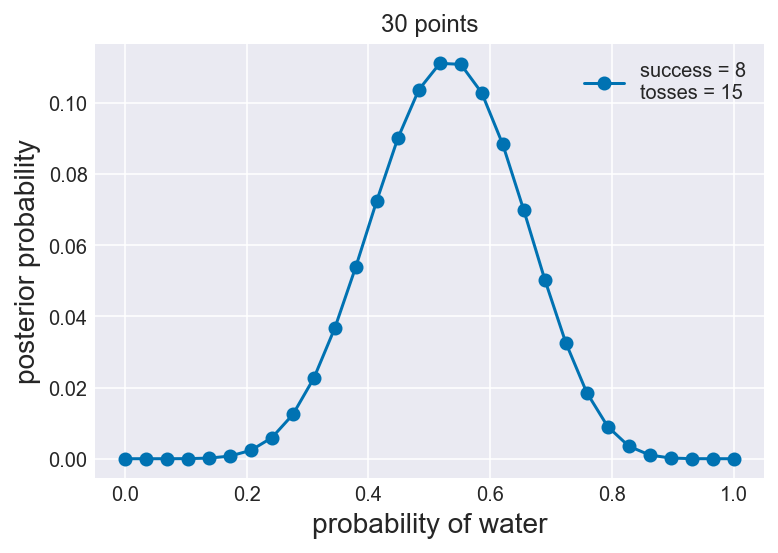

In [71]:
points = 30
w, n = 8, 15
prior = np.repeat(5,points)
p_grid, posterior = posterior_grid_approx(points, w, n, prior)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

#### 2)
Start over in 1, but now use a prior that is zero below p=0.5 and a constant above p=0.5. This corresponds to prior info that a majority of Earth's surface is water. What difference does the better prior make? If it helps, compare posterior distributions (using both priors) to the true value p=0.7

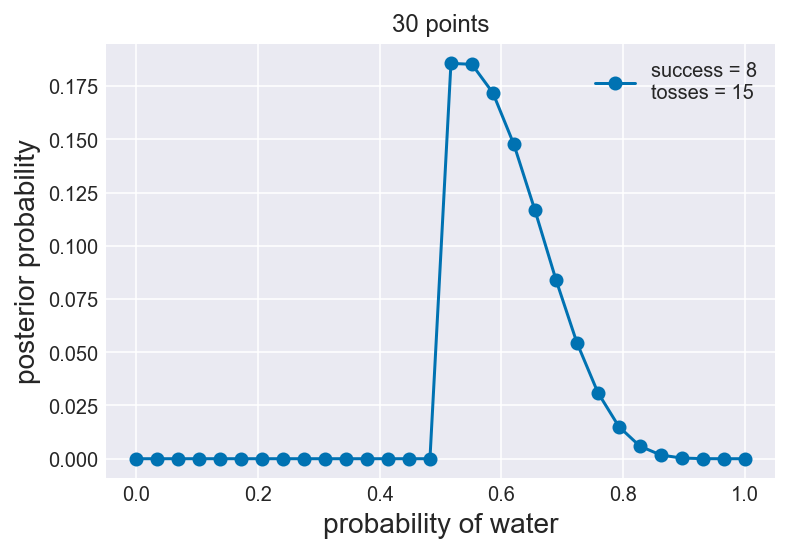

In [72]:
points = 30
w, n = 8, 15
prior = (np.linspace(0,1,points) >= 0.5).astype(int)
p_grid, posterior = posterior_grid_approx(points, w, n, prior)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

The better prior (zero below p = 0.5) yields a higher posterior probability that the probability of water = 0.7. This is because the area under the curve must sum to 1, and there is less space below this posterior's curve (meaning that the graph is streched higher).

#### 3)
This problem is more open-ended than the others. Feel free to colaborate on the solution. Suppose you want to estimate the Earth's proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this? I won't require a precise answer. I'm honestly more interested in your approach.

In [131]:
def percentile_interval(data, confidence):
    n = len(data)
    m = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n-1)
    interval = h*2
    return interval

In [143]:
def calculate_interval_based_on_tosses(tosses):
    p_true = 0.7
    w = stats.binom.rvs(tosses,p_true)
    p_grid = np.linspace(0,1,1000)
    prior = np.repeat(1,1000)
    prob_data = stats.binom.pmf(w,tosses, p_grid)
    posterior = prob_data * prior
    posterior = posterior / sum(posterior)
    samples = np.random.choice(p_grid, size=1000, p=posterior, replace=True)
    interval_vals = np.percentile(samples, [0.05, 99.5])
    print(interval_vals)
    interval = interval_vals[1] - interval_vals[0]
    return interval
        
        
        
#     # define grid
#     p_grid = np.linspace(0, 1, grid_points)

#     # define prior
#     if prior is None:
#         prior = np.repeat(5, grid_points)  # uniform
#     #prior = (p_grid >= 0.5).astype(int)  # truncated
#     #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

#     # compute likelihood at each point in the grid
#     likelihood = stats.binom.pmf(success, tosses, p_grid)

#     # compute product of likelihood and prior
#     unstd_posterior = likelihood * prior

#     # standardize the posterior, so it sums to 1
#     posterior = unstd_posterior / unstd_posterior.sum()
#     return p_grid, posterior

In [149]:
calculate_interval_based_on_tosses(2000)

[0.67217167 0.73273774]


0.06056606606606618

In [45]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running   and using:
Python 3.6.5
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2

